# Continuous optimization - Shifted Rosenbrock - dimension 500

## Importing libraries

In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
from numba import jit
from scipy import optimize
import pygmo as pg
from mpl_toolkits import mplot3d

In [2]:
path = '../data/'
export_path = '../data/'

Dict_funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}

funcs_name = {"sphere": "F1 : Shifted Sphere Function", "schwefel": "F2 : Schwefel’s Problem 2.21", "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

## Define a read function 

In [3]:
def read_values(func_name):
    values_path = str(path) + str(func_name) + '.csv'
    bias_path = str(path) + 'f_bias.csv'
    interval_path = str(path) + 'interval.csv'

    func_val = pd.read_csv(values_path)
    bias_val = pd.read_csv(bias_path)
    interval_df = pd.read_csv(interval_path,sep=';')

    funcval = func_val.List_values.values
    bias = bias_val.List_values.values[Dict_funcs[func_name]]
    search_space = list(interval_df.iloc[Dict_funcs[func_name],1:3])

    return funcval, bias, search_space

## Definition of the functions

In [4]:
@jit(nopython=True)
def eval_cost(x, dim):
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 # sum of z²
        result = F + bias # sum of z² + bias
    elif func_name == "schwefel":
        F = abs(x[0] - funcval[0]) # initial
        for i in range(1, dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z)) # max 'absZ_i, i in [1,D]}
        result = F + bias
    elif func_name == "rosenbrock":
        F = 0
        z = np.empty(dim)
        for i in range(dim - 1):
            z[i] = x[i] - funcval[i] + 1
        for i in range(dim - 2):
            F += 100 * (z[i + 1] ** 2 - z[i] ** 2) + (1 - z[i]) ** 2
        result = F + bias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + bias
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + bias
    elif func_name == "ackley":
        Sum_0 = 0
        Sum_1 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum_0 += z ** 2
            Sum_1 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum_0 / dim)) - math.exp(Sum_1 / dim) + 20 + math.e + bias
    else:
        result = 0
    return result

def plot_func(func_name):
    DIM = 2
    x = np.linspace(search_space[0], search_space[1], 250)
    X = np.meshgrid(x, x)

    if func_name == "sphere":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "schwefel":
        F = np.abs(X[0] - funcval[0]) # initial
        for i in range(1, DIM - 1):
            z = X[i] - funcval[i]
            F = np.max(F, np.abs(z))
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
    elif func_name == "rosenbrock":
        F = 0
        z = np.ndarray(DIM)

        for i in range(DIM - 1):
            z[i] = X[i] - np.ndarray(funcval[i]) + np.ndarray(1)
        for i in range(DIM - 2):
            F += 100 * (z[i + 1] ** 2.0 - z[i] ** 2.0) + (1 - z[i]) ** 2.0
            result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "rastrigin":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2 - 10 * np.cos(2 * np.pi * z) + 10
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += np.cos(z / np.sqrt(i + 1))
        result = F1 - F2 + 1 + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "ackley":
        Sum_0 = 0
        Sum_1 = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            Sum_0 += z ** 2
            Sum_1 += np.cos(2 * math.pi * z)
        result = -20 * np.exp(-0.2 * np.sqrt(Sum_0 / DIM)) - np.exp(Sum_1 / DIM) + 20 + math.e + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    else:
        result = 0

## Define problem Class

In [8]:
class Problem:
    def __init__(self, dim, bounds, glob_opt):
        self.lower = -bounds[1]
        self.upper = bounds[1]
        self.dim = dim
        self.fitness_per_eval = []
        self.glob_opt = glob_opt

    def fitness(self, x):
        result = abs(eval_cost(x, self.dim) - bias)
        return [result]

    def get_bounds(self):
        x_min = self.lower * np.ones(self.dim)
        x_max = self.upper * np.ones(self.dim)
        return x_min, x_max

## Represention in 2D of the function

In [9]:
path = '../data/'
func_name = 'rosenbrock'
funcval, bias, search_space = read_values(func_name)
# plot_func(func_name)

## Choice of the algorithm adapted for the problem

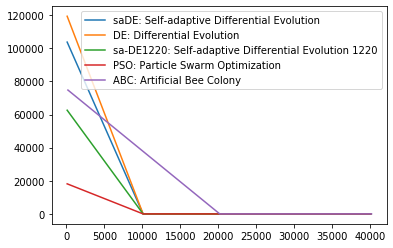

In [10]:
pop_size = 100
DIM = 500

%matplotlib inline

udas = [pg.sade(gen=500), pg.de(gen=500), pg.de1220(gen=500), pg.pso(gen=500), pg.bee_colony(gen=250, limit=20)]

for uda in udas:
     logs = []
     for i in range(25):
         algo = pg.algorithm(uda)
         algo.set_verbosity(1) # regulates both screen and log verbosity
         prob = pg.problem(Problem(DIM, search_space, bias))
         pop = pg.population(prob, pop_size)
         algo.set_verbosity(100)
         pop = algo.evolve(pop)
         logs.append(algo.extract(type(uda)).get_log())
     logs = np.array(logs)
     avg_log = np.average(logs,0)
     plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name())
     plt.legend()
plt.savefig("./Results/comparaison_rosenbrock_50" + ".png")
plt.show()

Artificial bee colony seems to be best algorithm to use: 

In [11]:
# define algorithm
DIM = 500
pop_size = 100
algo = pg.algorithm(pg.bee_colony(gen=5000,limit=1))
prob = pg.problem(Problem(DIM, search_space, bias))
pop = None
pop = pg.population(prob, pop_size)
algo.set_verbosity(100)

t1 = time.time()
pop = algo.evolve(pop)
t2 = time.time()
duration = t2 - t1
extract_algo = algo.extract(pg.bee_colony)
log = extract_algo.get_log()
curve = [x[2] for x in log]
nb_iter = log[-1][0]

#  Print and plot the solution of the problem function

----------------------------------------------------------------------------------------------------
Problem dimension: 50
Function: 2
Search Space :  [-100, 100]
Global Optimum: 390.00
----------------------------------------------------------------------------------------------------
Algorithm used: ABC: Artificial Bee Colony
Parameters used : 
	Maximum number of generations: 5000
	Limit: 1
	Verbosity: 100
	Seed: 1392276892
Fitness: 0.003819
Solution: 
            X
0  -44.777341
1  -74.549753
2  -50.117133
3   11.612934
..        ...
46  84.584439
47 -38.327901
48 -24.713923
49  -5.390950

[50 rows x 1 columns]
Number of iterations: 1000100
Stopping criterion: after 4901 iterations
computational time: 11.634 seconds


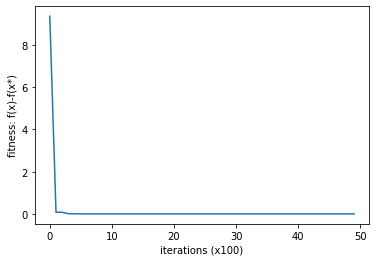

In [31]:
algorithm_name = algo.get_name()
parameters = algo.get_extra_info()
solution_x = pop.champion_x
fitness = pop.champion_f[0]
n_evals = pop.problem.get_fevals()
print('-' * 100)
print("Problem dimension: %d" % DIM)
print("Function: %s" % Dict_funcs[func_name])
print("Search Space : ", search_space)
print("Global Optimum: %.2f" % bias)
print('-' * 100)
print("Algorithm used: %s" % algorithm_name)
print("Parameters used : \n%s" % parameters)
print("Fitness: %f" % fitness)
print("Solution: ")
with pd.option_context('display.max_rows', 8):
    print(pd.DataFrame(solution_x, columns=['X']))
print("Number of iterations: %d" % n_evals)
print("Stopping criterion: after %d iterations" % nb_iter)
print("computational time: %.3f seconds" % duration)

plt.plot(curve)
plt.xlabel("iterations (x100)")
plt.ylabel("fitness: f(x)-f(x*)")
plt.savefig("./Results/sol_rosenbrock_50" + ".png")
plt.show()